In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
from tqdm import tqdm
print(torch.__version__)

2.5.1+cu121


In [3]:
train= pd.read_csv('../input/aptos2019/train_1.csv')
test= pd.read_csv('../input/aptos2019/test.csv')

In [4]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  2930
Number of test samples:  366


,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


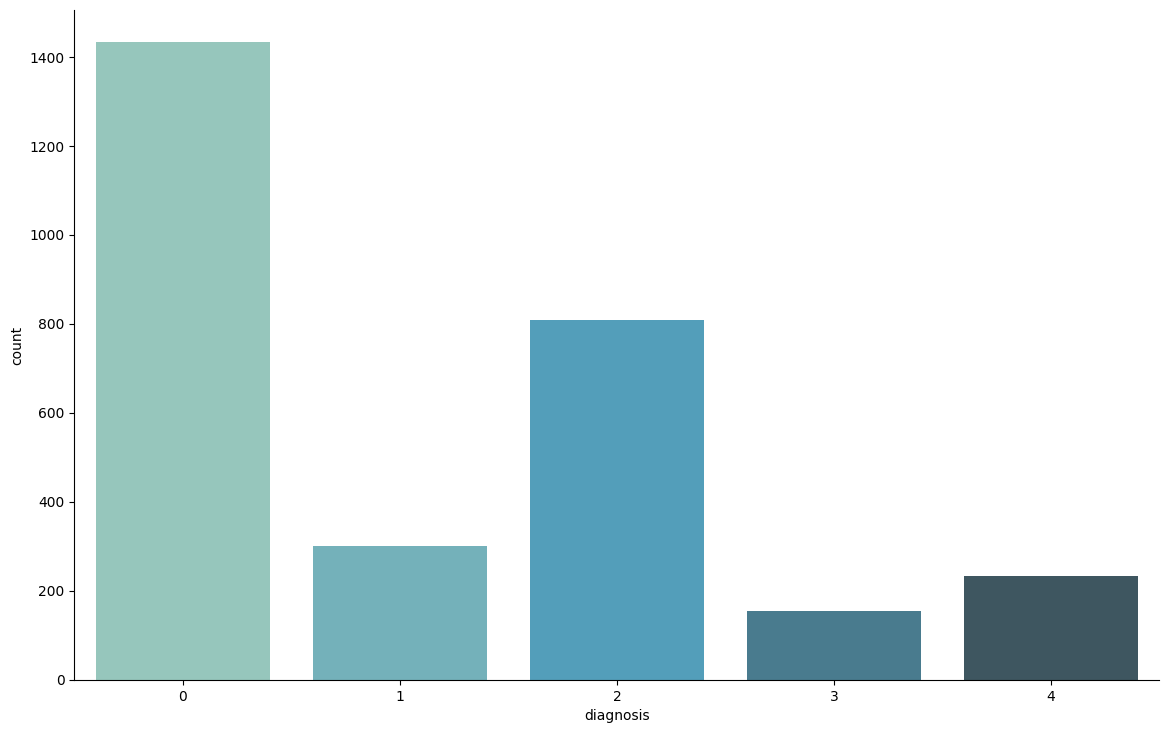

In [5]:
import pandas as pd
f, ax = plt.subplots(figsize=(14, 8.7))
train= pd.read_csv('../input/aptos2019/train_1.csv')
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

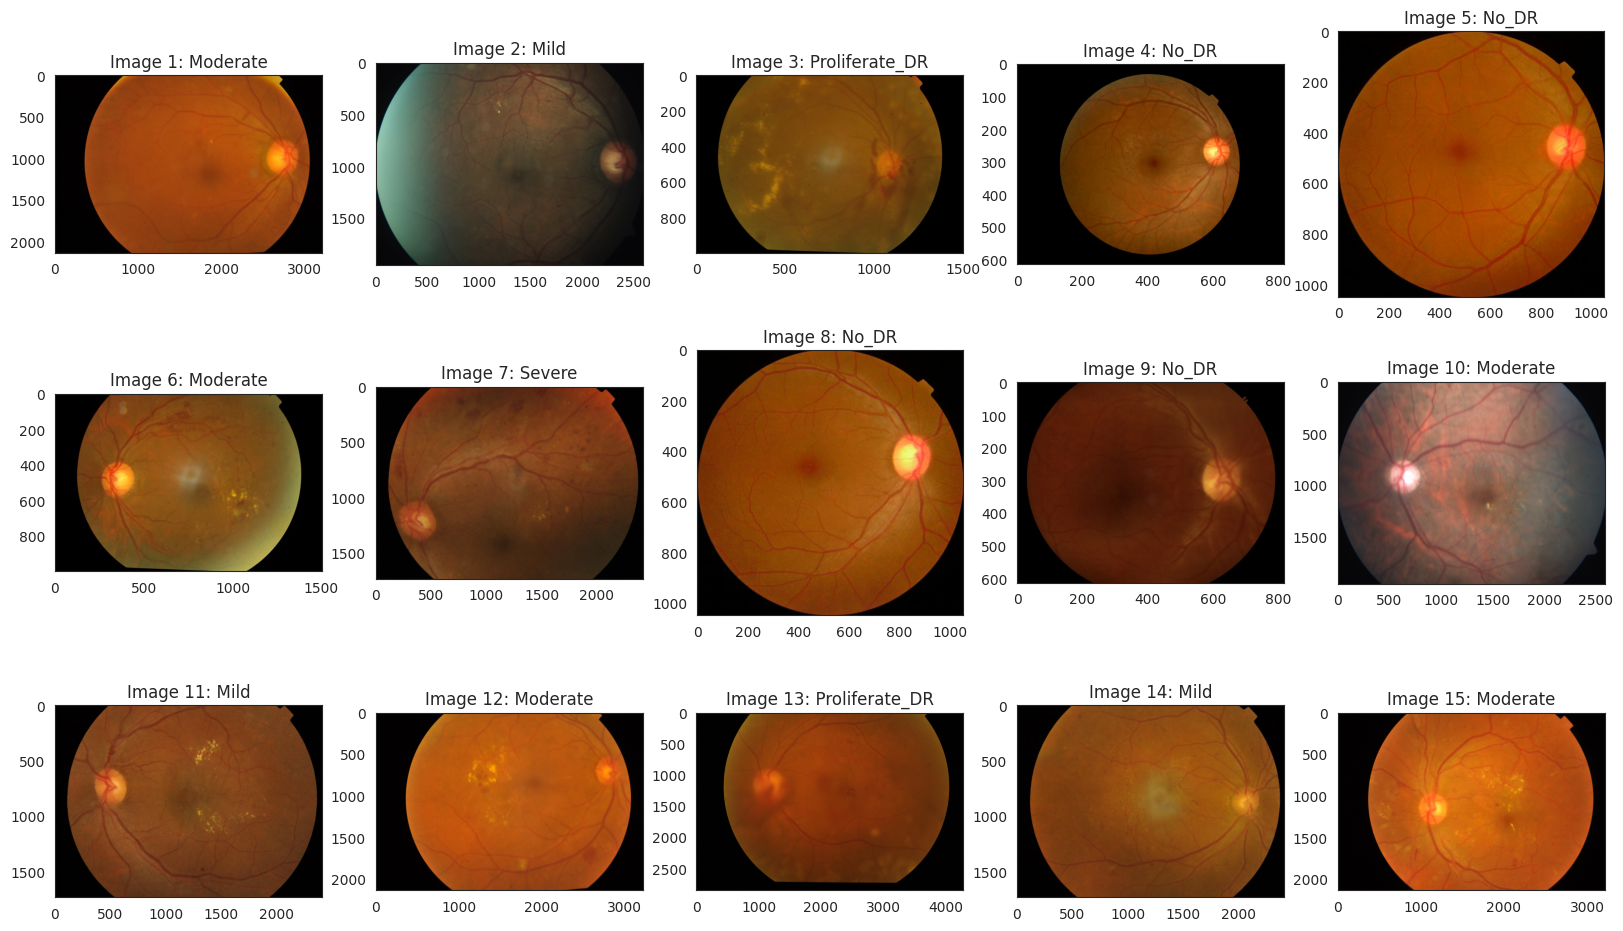

In [6]:
# Setting the style for the plot
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"../input/aptos2019/train_images/train_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1

# Display the plot
plt.show()


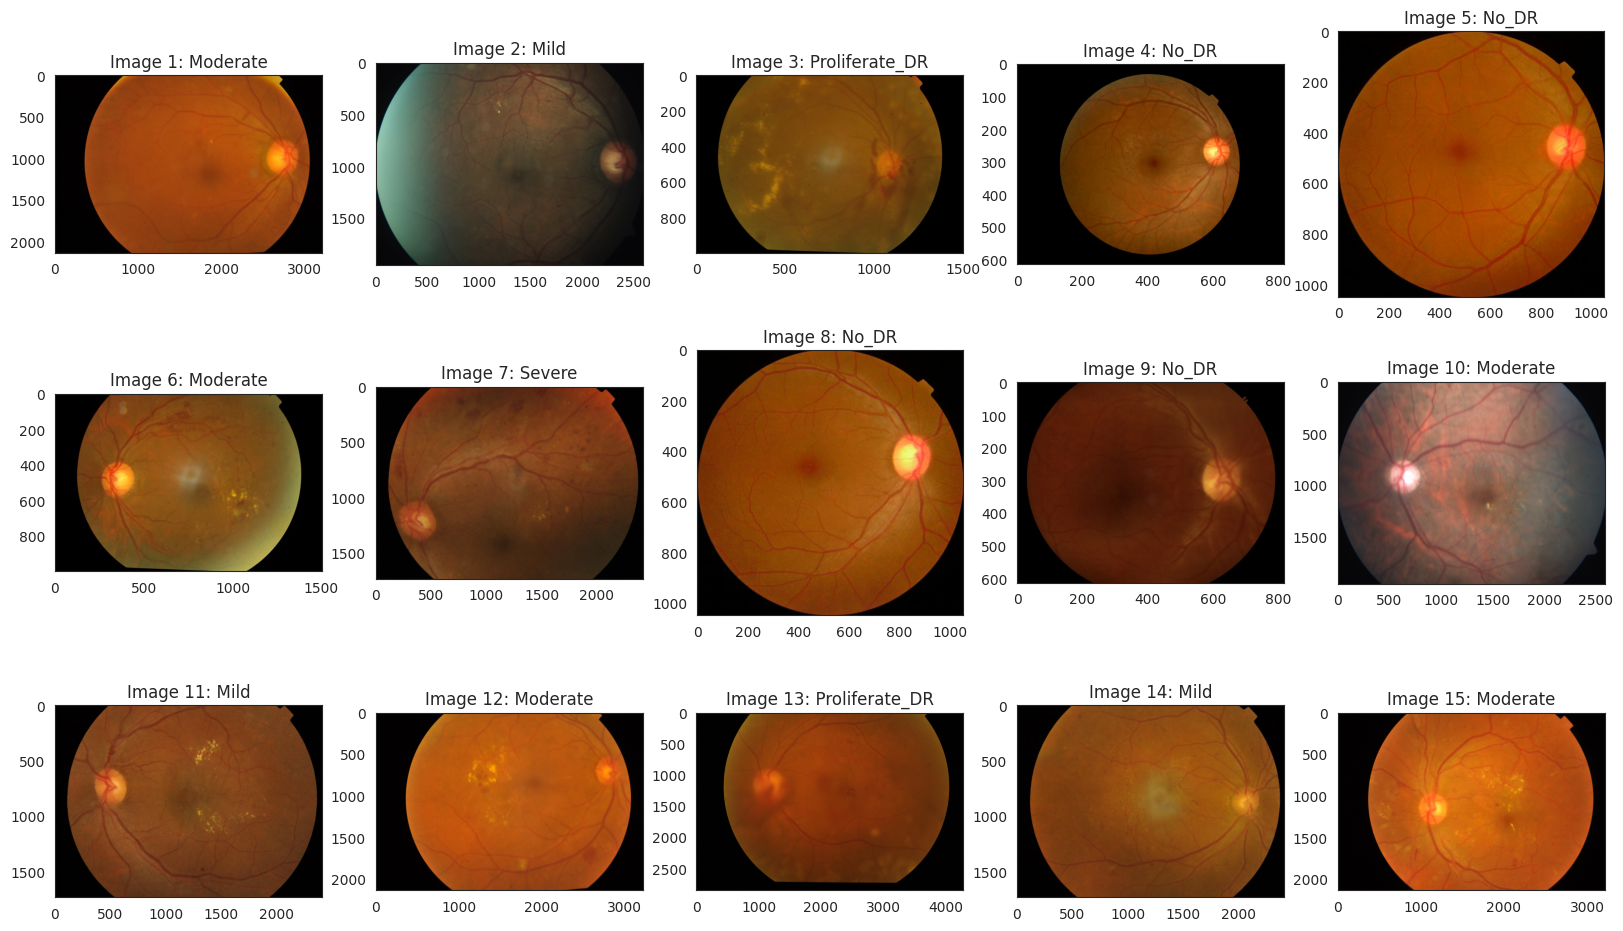

In [7]:

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"../input/aptos2019/train_images/train_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1

# Display the plot
plt.show()


In [8]:
DATA_DIR = "../input/aptos2019/"
TRAIN_DIR = "../input/aptos2019/train_images/train_images"
CSV_PATH = "../input/aptos2019/train_1.csv"
MODEL_PATH = "./kaggle/working/"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
IMG_WIDTH= 256
IMG_HEIGHT= 256
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS=25

In [9]:
from torch.utils.data import Dataset
import torch
import pandas as pd
import os
from torchvision.io import read_image  # Ensure read_image is imported
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [10]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
train_trasforms_DeiT_base_patch16= T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Resize((IMG_WIDTH, IMG_HEIGHT)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_DeiT_base_patch16)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

In [11]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k.

    Args:
        output (torch.Tensor): Model predictions with shape (batch_size, num_classes).
        target (torch.Tensor): True labels with shape (batch_size,).
        topk (tuple): Tuple of integers indicating top-k values to calculate.

    Returns:
        list: Accuracy values for each top-k specified.
    """
    maxk = max(topk)  # Determine the maximum k
    batch_size = target.size(0)  # Get the batch size
    _, pred = output.topk(maxk, 1, True, True)  # Get top-k predictions
    pred = pred.t()  # Transpose for comparison
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))  # Check correctness
    return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]


def set_debug_apis(state: bool = False):
    """
    Configures PyTorch debugging tools.

    Args:
        state (bool): If True, enables debugging tools for profiling and anomaly detection.
    """
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    """
    Sets seeds for reproducibility in training.

    Args:
        seed (int): Seed value to ensure determinism.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Seed for hash-based operations
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # Seed for PyTorch (GPU)
    torch.backends.cudnn.deterministic = True  # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN


def print_size_of_model(model):
    """
    Calculates and prints the size of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose size is to be calculated.
    """
    torch.save(model.state_dict(), "temp.p")  # Save model state
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)  # Convert bytes to MB
    os.remove("temp.p")  # Clean up temporary file


class AverageMeter(object):
    """
    Computes and stores the average and current value of a metric.
    Useful for tracking performance metrics during training or evaluation.
    """

    def __init__(self):
        self.reset()  # Initialize/reset all attributes

    def reset(self):
        """Resets all statistics to their initial state."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        Updates statistics with a new value.

        Args:
            val (float): New value to update.
            n (int): Weight of the value (e.g., batch size).
        """
        self.val = val  # Current value
        self.sum += val * n  # Accumulated value
        self.count += n  # Count of items
        self.avg = self.sum / self.count  # Average


In [12]:
!nvidia-smi


Tue Mar 11 11:27:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
import torch
print(torch.cuda.is_available())


True


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict
from torch.cuda import amp 
def train_step(model: nn.Module, train_loader, criterion,
               device: str, optimizer,
               scheduler=None, num_batches: int = None,
               log_interval: int = 100,
               scaler=None,):
    """
    Performs one step of training. Calculates loss, forward pass, computes gradient and returns metrics.
    Args:
        model : A pytorch CNN Model.
        train_loader : Train loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        optimizer : Torch optimizer to train.
        scheduler : Learning rate scheduler.
        num_batches : (optional) Integer To limit training to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
        scaler: (optional)  Pass torch.cuda.amp.GradScaler() for fp16 precision Training.
    """

    model = model.to(device)
    start_train_step = time.time()
    metrics = OrderedDict()
    model.train()
    last_idx = len(train_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    batch_start = time.time()
    # num_updates = epoch * len(loader)

    for batch_idx, (inputs, target) in enumerate(train_loader):
        last_batch = batch_idx == last_idx
        # data_time_m.update(time.time() - batch_start)
        inputs = inputs.to(device)
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        if scaler is not None:
            with amp.autocast():
                output = model(inputs)
                loss = criterion(output, target)
                # Scale the loss using Grad Scaler
            scaler.scale(loss).backward()
            # Step using scaler.step()
            scaler.step(optimizer)
            # Update for next iteration
            scaler.update()

        else:
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        losses_m.update(loss.item(), inputs.size(0))

        batch_time_m.update(time.time() - batch_start)
        batch_start = time.time()
        if last_batch or batch_idx % log_interval == 0:  # If we reach the log intervel
            print(
                "Batch Train Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_train_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} train batches")
                print(f"Time taken for train step = {end_train_step - start_train_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    end_train_step = time.time()
    print(f"Time taken for train step = {end_train_step - start_train_step} sec")
    return metrics

In [15]:
@torch.no_grad()
def val_step(model: nn.Module, val_loader, criterion,
             device: str, num_batches=None,
             log_interval: int = 100):

    """
    Performs one step of validation. Calculates loss, forward pass and returns metrics.
    Args:
        model : A pytorch CNN Model.
        val_loader : Validation loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        num_batches : (optional) Integer To limit validation to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
    """

    model = model.to(device)
    start_val_step = time.time()
    last_idx = len(val_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    model.eval()
    batch_start = time.time()
    metrics = OrderedDict()

    for batch_idx, (inputs, target) in enumerate(val_loader):
        last_batch = batch_idx == last_idx
        inputs = inputs.to(device)
        target = target.to(device)

        output = model(inputs)
        loss = criterion(output, target)
        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        reduced_loss = loss.data

        losses_m.update(reduced_loss.item(), inputs.size(0))
        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        batch_time_m.update(time.time() - batch_start)

        batch_start = time.time()

        if (last_batch or batch_idx % log_interval == 0):  # If we reach the log intervel
            print(
                "Batch Inference Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_val_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} validation batches")
                print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    print("Finished the validation epoch")

    end_val_step = time.time()
    print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
    return metrics

In [16]:
!pip install lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.5 MB/s eta 0:00:00


In [17]:
from lightning import seed_everything

MODEL_NAME = "swinv2_small_window16_256"
MODEL_SAVE = "/kaggle/working/fastvit_s12.Csv"

seed_everything(42)  # Set seed for reproducibility


INFO: Seed set to 42


42

In [18]:
import timm
print(timm.models.list_models())  # List all available models


['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [19]:
model= timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
USE_AMP = True  # or False, depending on whether you want to use AMP
if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

<ipython-input-19-e80de8510f9d>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [20]:
print(f"Train Loader: {train_loader}")


Train Loader: <torch.utils.data.dataloader.DataLoader object at 0x79d8095ac460>


In [21]:
import time
import pandas as pd
import torch
from tqdm import tqdm
MODEL_NAME = "swinv2_small_window16_256"
MODEL_SAVE = "/kaggle/working/fastvit_s12.Csv"


EPOCHS = 25  # Set the number of epochs

# Initialize lists to store metrics
train_loss = []
train_top1_acc = []
val_loss = []
val_top1_acc = []

# Record start time
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
    train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
    train_loss.append(train_metrics["loss"])
    print(f"Training loss = {train_metrics['loss']}")
    train_top1_acc.append(train_metrics["top1"])

    val_metrics = val_step(model, val_loader, criterion, device)
    val_loss.append(val_metrics["loss"])
    print(f"Validation loss = {val_metrics['loss']}")
    val_top1_acc.append(val_metrics["top1"])
    
    # Save model checkpoint
    checkpoint_path = f"{MODEL_NAME}_{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

# Record end time
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_top1_acc": train_top1_acc,
    "val_loss": val_loss,
    "val_top1_acc": val_top1_acc,
})

# Save the DataFrame to CSV
metrics_df.to_csv(MODEL_SAVE, index=False)


  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-14-d38c5aef8890>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Batch Train Time: 7.530 (7.530)  Loss:  1.6069 (1.6069)  Top 1 Accuracy: 28.1250 (28.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.945 (2.666)  Loss:  0.6771 (0.6862)  Top 1 Accuracy: 75.0000 (74.6909)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 242.6593520641327 sec
Training loss = 0.686171388888097
Batch Inference Time: 7.190 (7.190)  Loss:  0.5866 (0.5866)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.254 (2.893)  Loss:  0.5122 (0.5374)  Top 1 Accuracy: 81.2500 (80.2083)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 52.129284143447876 sec
Validation loss = 0.5374252266354032


  4%|▍         | 1/25 [04:55<1:58:06, 295.28s/it]

Batch Train Time: 6.570 (6.570)  Loss:  0.5757 (0.5757)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.141 (2.792)  Loss:  0.5707 (0.4430)  Top 1 Accuracy: 81.2500 (83.6538)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.09451508522034 sec
Training loss = 0.44298032712150404
Batch Inference Time: 6.463 (6.463)  Loss:  0.3359 (0.3359)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.336 (2.846)  Loss:  0.3353 (0.3652)  Top 1 Accuracy: 87.5000 (88.7153)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.294564723968506 sec
Validation loss = 0.3651915979054239


  8%|▊         | 2/25 [10:00<1:55:32, 301.41s/it]

Batch Train Time: 7.046 (7.046)  Loss:  0.3938 (0.3938)  Top 1 Accuracy: 84.3750 (84.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.070 (2.813)  Loss:  0.3029 (0.3555)  Top 1 Accuracy: 87.5000 (86.7445)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 256.0184121131897 sec
Training loss = 0.35553240366689454
Batch Inference Time: 7.114 (7.114)  Loss:  0.2358 (0.2358)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.812 (2.846)  Loss:  0.1969 (0.2475)  Top 1 Accuracy: 96.8750 (90.9722)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.27044320106506 sec
Validation loss = 0.24748841341998842


 12%|█▏        | 3/25 [15:08<1:51:33, 304.23s/it]

Batch Train Time: 6.575 (6.575)  Loss:  0.3122 (0.3122)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.076 (2.822)  Loss:  0.2068 (0.2893)  Top 1 Accuracy: 96.8750 (89.0797)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 256.8837194442749 sec
Training loss = 0.2893230963375542
Batch Inference Time: 6.578 (6.578)  Loss:  0.2423 (0.2423)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.254 (2.880)  Loss:  0.1696 (0.1954)  Top 1 Accuracy: 93.7500 (92.7083)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.89045333862305 sec
Validation loss = 0.19535668214990032


 16%|█▌        | 4/25 [20:17<1:47:08, 306.14s/it]

Batch Train Time: 6.557 (6.557)  Loss:  0.2508 (0.2508)  Top 1 Accuracy: 84.3750 (84.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.096 (2.801)  Loss:  0.0925 (0.2125)  Top 1 Accuracy: 96.8750 (92.5481)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.93403935432434 sec
Training loss = 0.21253675668612942
Batch Inference Time: 6.746 (6.746)  Loss:  0.1167 (0.1167)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.254 (2.799)  Loss:  0.1727 (0.1568)  Top 1 Accuracy: 93.7500 (95.1389)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 50.42814540863037 sec
Validation loss = 0.1568149117132028


 20%|██        | 5/25 [25:23<1:41:59, 305.97s/it]

Batch Train Time: 6.602 (6.602)  Loss:  0.1000 (0.1000)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.870 (2.792)  Loss:  0.1087 (0.1825)  Top 1 Accuracy: 96.8750 (93.4409)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.13002490997314 sec
Training loss = 0.1825412198655553
Batch Inference Time: 6.609 (6.609)  Loss:  0.0755 (0.0755)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 2.371 (2.868)  Loss:  0.0457 (0.0969)  Top 1 Accuracy: 96.8750 (97.0486)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.67082762718201 sec
Validation loss = 0.09689595446818405


 24%|██▍       | 6/25 [30:29<1:36:54, 306.01s/it]

Batch Train Time: 7.003 (7.003)  Loss:  0.1236 (0.1236)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.888 (2.815)  Loss:  0.0860 (0.1707)  Top 1 Accuracy: 93.7500 (94.1621)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 256.2204818725586 sec
Training loss = 0.17069901210757402
Batch Inference Time: 6.552 (6.552)  Loss:  0.0585 (0.0585)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 1.796 (2.840)  Loss:  0.0967 (0.1394)  Top 1 Accuracy: 96.8750 (94.9653)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.17375707626343 sec
Validation loss = 0.13937601240144837


 28%|██▊       | 7/25 [35:37<1:31:58, 306.56s/it]

Batch Train Time: 6.517 (6.517)  Loss:  0.0583 (0.0583)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.054 (2.782)  Loss:  0.0797 (0.1407)  Top 1 Accuracy: 96.8750 (94.7459)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.22788047790527 sec
Training loss = 0.14067344961094333
Batch Inference Time: 6.405 (6.405)  Loss:  0.2414 (0.2414)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.253 (2.838)  Loss:  0.2140 (0.2491)  Top 1 Accuracy: 93.7500 (92.1875)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.1415376663208 sec
Validation loss = 0.24911655195885235


 32%|███▏      | 8/25 [40:41<1:26:41, 305.95s/it]

Batch Train Time: 6.527 (6.527)  Loss:  0.2730 (0.2730)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.062 (2.790)  Loss:  0.3113 (0.1090)  Top 1 Accuracy: 90.6250 (96.0165)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.9319543838501 sec
Training loss = 0.10901175971542086
Batch Inference Time: 6.472 (6.472)  Loss:  0.0443 (0.0443)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.253 (2.873)  Loss:  0.5761 (0.4195)  Top 1 Accuracy: 87.5000 (89.7569)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.76680588722229 sec
Validation loss = 0.41951967486076885


 36%|███▌      | 9/25 [45:47<1:21:35, 305.96s/it]

Batch Train Time: 6.480 (6.480)  Loss:  0.1415 (0.1415)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.243 (2.796)  Loss:  0.1490 (0.1054)  Top 1 Accuracy: 93.7500 (96.2225)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.4713945388794 sec
Training loss = 0.10544342944746489
Batch Inference Time: 6.448 (6.448)  Loss:  0.0195 (0.0195)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.691 (2.836)  Loss:  0.0092 (0.0770)  Top 1 Accuracy: 100.0000 (97.7431)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.09241485595703 sec
Validation loss = 0.07695959038877238


 40%|████      | 10/25 [50:53<1:16:28, 305.93s/it]

Batch Train Time: 6.656 (6.656)  Loss:  0.0810 (0.0810)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.054 (2.795)  Loss:  0.1633 (0.0927)  Top 1 Accuracy: 96.8750 (96.2912)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.35246658325195 sec
Training loss = 0.09271733712527779
Batch Inference Time: 6.616 (6.616)  Loss:  0.0582 (0.0582)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.254 (2.873)  Loss:  0.0148 (0.0982)  Top 1 Accuracy: 100.0000 (96.3542)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.76916313171387 sec
Validation loss = 0.09822918831681211


 44%|████▍     | 11/25 [55:59<1:11:25, 306.08s/it]

Batch Train Time: 6.447 (6.447)  Loss:  0.2202 (0.2202)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.086 (2.776)  Loss:  0.0104 (0.0841)  Top 1 Accuracy: 100.0000 (96.7376)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 252.64368200302124 sec
Training loss = 0.08408463787246537
Batch Inference Time: 6.406 (6.406)  Loss:  0.0311 (0.0311)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.555 (2.833)  Loss:  0.0241 (0.1026)  Top 1 Accuracy: 100.0000 (97.0486)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.04132914543152 sec
Validation loss = 0.10259350689335002


 48%|████▊     | 12/25 [1:01:03<1:06:10, 305.44s/it]

Batch Train Time: 6.670 (6.670)  Loss:  0.1166 (0.1166)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.419 (2.749)  Loss:  0.0646 (0.0495)  Top 1 Accuracy: 96.8750 (98.0769)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 250.16873025894165 sec
Training loss = 0.049493284875547494
Batch Inference Time: 6.431 (6.431)  Loss:  0.0050 (0.0050)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.255 (2.819)  Loss:  0.0030 (0.0341)  Top 1 Accuracy: 100.0000 (98.9583)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 50.80126094818115 sec
Validation loss = 0.03411974668658028


 52%|█████▏    | 13/25 [1:06:05<1:00:50, 304.18s/it]

Batch Train Time: 6.898 (6.898)  Loss:  0.0487 (0.0487)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.099 (2.778)  Loss:  0.0434 (0.0390)  Top 1 Accuracy: 96.8750 (98.4890)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 252.81030583381653 sec
Training loss = 0.03897485267984998
Batch Inference Time: 6.400 (6.400)  Loss:  0.0011 (0.0011)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 1.120 (2.848)  Loss:  0.0008 (0.0322)  Top 1 Accuracy: 100.0000 (99.3056)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.31978154182434 sec
Validation loss = 0.03218187975289766


 56%|█████▌    | 14/25 [1:11:09<55:46, 304.25s/it]  

Batch Train Time: 6.561 (6.561)  Loss:  0.0474 (0.0474)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.103 (2.789)  Loss:  0.0483 (0.0285)  Top 1 Accuracy: 96.8750 (98.5577)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.87529182434082 sec
Training loss = 0.02850539736695342
Batch Inference Time: 6.492 (6.492)  Loss:  0.0005 (0.0005)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.253 (2.742)  Loss:  0.0004 (0.0301)  Top 1 Accuracy: 100.0000 (99.1319)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 49.40882682800293 sec
Validation loss = 0.030075901034352783


 60%|██████    | 15/25 [1:16:13<50:40, 304.05s/it]

Batch Train Time: 6.548 (6.548)  Loss:  0.0425 (0.0425)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.868 (2.781)  Loss:  0.0533 (0.0260)  Top 1 Accuracy: 96.8750 (98.3173)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.1133952140808 sec
Training loss = 0.026028027082537555
Batch Inference Time: 6.577 (6.577)  Loss:  0.0004 (0.0004)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.933 (2.812)  Loss:  0.0001 (0.0341)  Top 1 Accuracy: 100.0000 (98.7847)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 50.662354946136475 sec
Validation loss = 0.03409008759455093


 64%|██████▍   | 16/25 [1:21:17<45:36, 304.05s/it]

Batch Train Time: 6.812 (6.812)  Loss:  0.0329 (0.0329)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.609 (2.791)  Loss:  0.0250 (0.0180)  Top 1 Accuracy: 100.0000 (98.7981)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.04467034339905 sec
Training loss = 0.018026782261146294
Batch Inference Time: 6.603 (6.603)  Loss:  0.0002 (0.0002)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.255 (2.841)  Loss:  0.0000 (0.0315)  Top 1 Accuracy: 100.0000 (99.1319)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.182591676712036 sec
Validation loss = 0.03145502141230989


 68%|██████▊   | 17/25 [1:26:22<40:35, 304.49s/it]

Batch Train Time: 6.531 (6.531)  Loss:  0.0304 (0.0304)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.081 (2.789)  Loss:  0.0440 (0.0545)  Top 1 Accuracy: 96.8750 (98.0426)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.8501443862915 sec
Training loss = 0.05445962591649412
Batch Inference Time: 6.574 (6.574)  Loss:  0.0089 (0.0089)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.256 (2.833)  Loss:  0.0006 (0.0414)  Top 1 Accuracy: 100.0000 (98.6111)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.04648208618164 sec
Validation loss = 0.04138289987006121


 72%|███████▏  | 18/25 [1:31:28<35:32, 304.70s/it]

Batch Train Time: 6.909 (6.909)  Loss:  0.0353 (0.0353)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.223 (2.791)  Loss:  0.0402 (0.0362)  Top 1 Accuracy: 96.8750 (98.5234)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 254.05143094062805 sec
Training loss = 0.03616807712139664
Batch Inference Time: 6.455 (6.455)  Loss:  0.0032 (0.0032)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.412 (2.868)  Loss:  0.0124 (0.0487)  Top 1 Accuracy: 100.0000 (98.2639)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.67462205886841 sec
Validation loss = 0.04869628730456396


 76%|███████▌  | 19/25 [1:36:34<30:30, 305.10s/it]

Batch Train Time: 6.542 (6.542)  Loss:  0.1237 (0.1237)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.078 (2.789)  Loss:  0.0374 (0.0514)  Top 1 Accuracy: 96.8750 (97.5275)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 253.84119772911072 sec
Training loss = 0.05136699282697269
Batch Inference Time: 6.517 (6.517)  Loss:  0.0028 (0.0028)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 1.676 (2.824)  Loss:  0.1218 (0.0516)  Top 1 Accuracy: 96.8750 (98.2639)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 50.88406586647034 sec
Validation loss = 0.05155398220732524


 80%|████████  | 20/25 [1:41:39<25:25, 305.08s/it]

Batch Train Time: 6.522 (6.522)  Loss:  0.0353 (0.0353)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.038 (2.803)  Loss:  0.0424 (0.0561)  Top 1 Accuracy: 96.8750 (97.8365)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 255.10140323638916 sec
Training loss = 0.05605570276032437
Batch Inference Time: 6.536 (6.536)  Loss:  0.0026 (0.0026)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 2.315 (2.863)  Loss:  0.0628 (0.0432)  Top 1 Accuracy: 96.8750 (98.4375)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.584620237350464 sec
Validation loss = 0.04321740983545573


 84%|████████▍ | 21/25 [1:46:46<20:22, 305.65s/it]

Batch Train Time: 6.549 (6.549)  Loss:  0.0236 (0.0236)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.113 (2.767)  Loss:  0.0926 (0.0492)  Top 1 Accuracy: 96.8750 (98.0769)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 251.87484574317932 sec
Training loss = 0.049197917169594506
Batch Inference Time: 6.811 (6.811)  Loss:  0.0048 (0.0048)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.256 (2.862)  Loss:  0.0015 (0.0361)  Top 1 Accuracy: 100.0000 (99.1319)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.57075214385986 sec
Validation loss = 0.03608196505552365


 88%|████████▊ | 22/25 [1:51:49<15:15, 305.08s/it]

Batch Train Time: 6.552 (6.552)  Loss:  0.1203 (0.1203)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.007 (2.775)  Loss:  0.0216 (0.0284)  Top 1 Accuracy: 100.0000 (98.6607)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 252.59620809555054 sec
Training loss = 0.028400810251196663
Batch Inference Time: 6.384 (6.384)  Loss:  0.0003 (0.0003)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.734 (2.821)  Loss:  0.0001 (0.0306)  Top 1 Accuracy: 100.0000 (98.9583)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 50.82988166809082 sec
Validation loss = 0.030564910138410697


 92%|█████████▏| 23/25 [1:56:53<10:09, 304.67s/it]

Batch Train Time: 6.731 (6.731)  Loss:  0.0288 (0.0288)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.069 (2.807)  Loss:  0.0328 (0.0222)  Top 1 Accuracy: 96.8750 (98.6951)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 255.44767594337463 sec
Training loss = 0.022175967611454347
Batch Inference Time: 6.454 (6.454)  Loss:  0.0005 (0.0005)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 2.234 (2.841)  Loss:  0.0000 (0.0314)  Top 1 Accuracy: 100.0000 (98.9583)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 51.196977376937866 sec
Validation loss = 0.031416438852021306


 96%|█████████▌| 24/25 [2:02:00<05:05, 305.35s/it]

Batch Train Time: 6.495 (6.495)  Loss:  0.0409 (0.0409)  Top 1 Accuracy: 96.8750 (96.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 4.321 (2.778)  Loss:  0.0305 (0.0223)  Top 1 Accuracy: 96.8750 (98.4890)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 252.88670945167542 sec
Training loss = 0.02233542067991508
Batch Inference Time: 6.478 (6.478)  Loss:  0.0007 (0.0007)  Top 1 Accuracy: 100.0000 (100.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 0.253 (2.727)  Loss:  0.0002 (0.0344)  Top 1 Accuracy: 100.0000 (99.1319)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 49.13620662689209 sec
Validation loss = 0.034421441923768725


100%|██████████| 25/25 [2:07:02<00:00, 304.91s/it]

Total training time: 7622.79 seconds


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Visualization saved to swinv2_small_window16_256_training_visualization.png


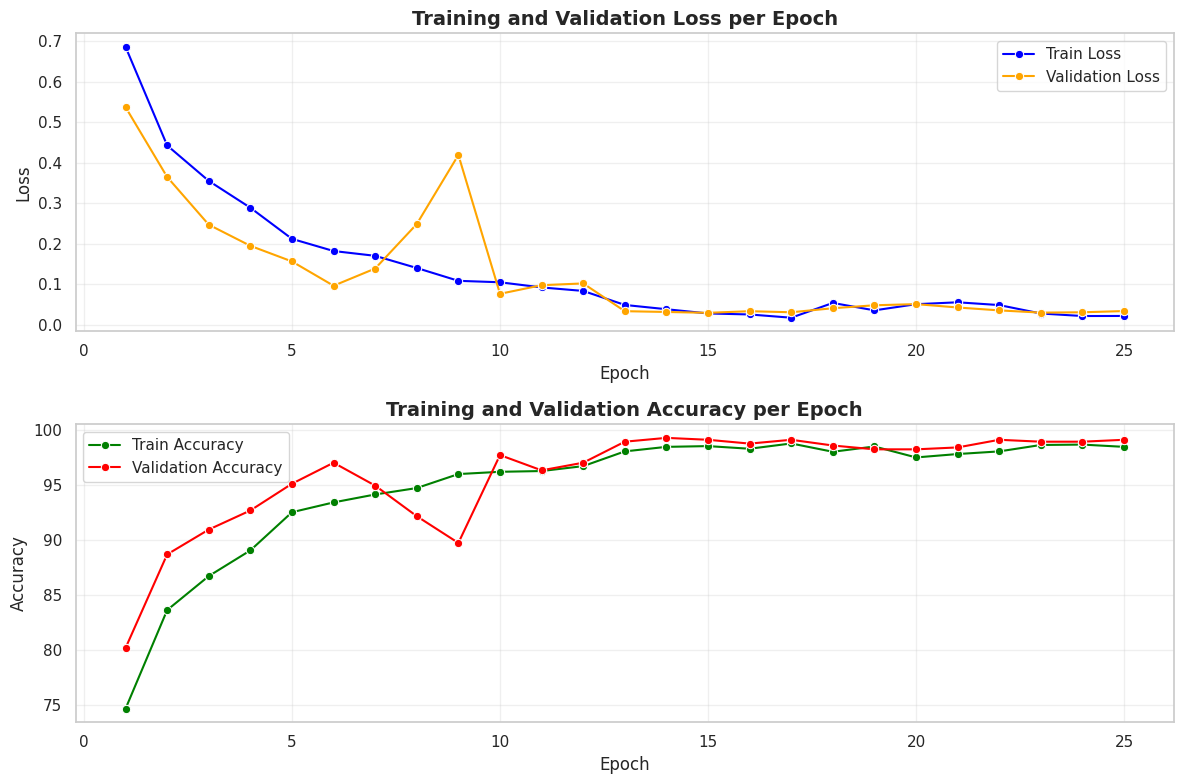

In [65]:
metrics_path = "/kaggle/working/fastvit_s12.Csv"  # Path to metrics CSV
metrics_df = pd.read_csv(metrics_path)

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue', marker="o")
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange', marker="o")
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_top1_acc', data=metrics_df, label='Train Accuracy', color='green', marker="o")
sns.lineplot(x='epoch', y='val_top1_acc', data=metrics_df, label='Validation Accuracy', color='red', marker="o")
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file (optional)
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [66]:
# Load your model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

In [67]:
# Predict on validation data
def predict_on_validation(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in val_loader:  # Assuming dataloader is a dictionary with 'val' key
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [72]:
# Define paths and device
checkpoint_path = "/kaggle/working/swinv2_small_window16_256_23.pt"
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model= load_model_from_checkpoint(checkpoint_path, model_class, device)

# Assuming `dataloaders` is a dictionary with 'val' key containing the validation dataloader
# Predict on validation set
y_true, y_pred = predict_on_validation(model, val_loader, device)

<ipython-input-66-baa69874f734>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [73]:
# Generate Classification Report
report = classification_report(y_true, y_pred, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       273
           1       0.99      1.00      0.99        69
           2       0.98      0.99      0.98       165
           3       0.94      0.97      0.96        34
           4       1.00      0.91      0.96        35

    accuracy                           0.99       576
   macro avg       0.98      0.97      0.98       576
weighted avg       0.99      0.99      0.99       576



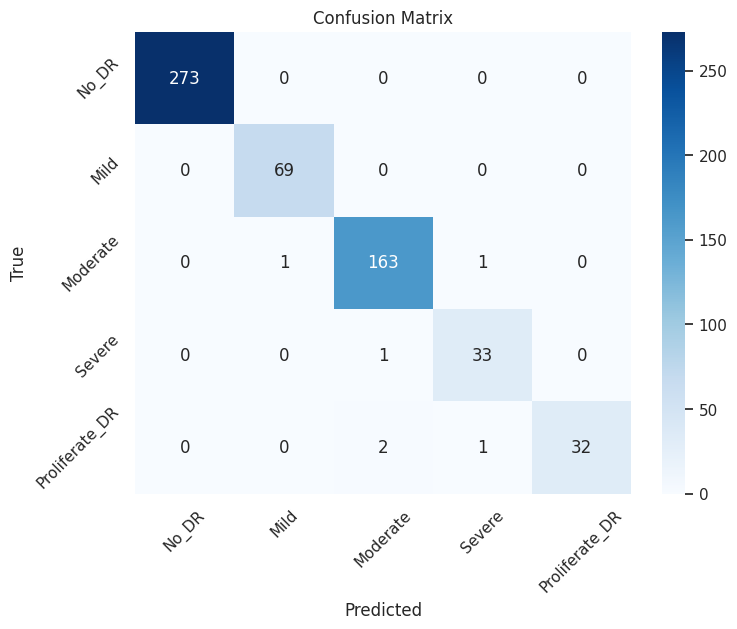

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the mapping of class labels to category names
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[level_to_category[i] for i in range(cm.shape[0])],
            yticklabels=[level_to_category[i] for i in range(cm.shape[0])])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('/kaggle/working/Confision.png')
plt.show()


In [76]:


# Calculate errors per class (misclassifications)
class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])  # Total number of instances of class i
    incorrect = total - cm[i, i]  # Misclassified instances of class i
    error_rate = incorrect / total if total != 0 else 0
    class_errors[level_to_category[i]] = round(error_rate, 4)  # Round error_rate and map to class name

# Print class errors
for class_name, error_rate in class_errors.items():
    print(f"Class {class_name}: Error Rate = {error_rate}")


Class No_DR: Error Rate = 0.0
Class Mild: Error Rate = 0.0
Class Moderate: Error Rate = 0.0121
Class Severe: Error Rate = 0.0294
Class Proliferate_DR: Error Rate = 0.0857


In [77]:
# Create a DataFrame for the error rates
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])


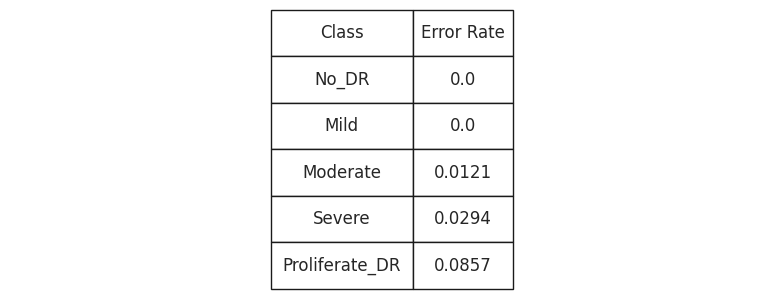

In [78]:
# Plot only the table, fitting the entire figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)

plt.tight_layout()
plt.savefig('/kaggle/working/TableSWINAdamW.png')

plt.show()
